In [ ]:
# Install dependencies
pip install pennylane torch scikit-learn

   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/203.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/203.1 MB 645.7 kB/s eta 0:05:14
   ---------------------------------------- 0.5/203.1 MB 645.7 kB/s eta 0:05:14
   ---------------------------------------- 0.8/203.1 MB 657.8 kB/s eta 0:05:08
   ---------------------------------------- 0.8/203.1 MB 657.8 kB/s eta 0:05:08
   ---------------------------------------- 1.0/203.1 MB 592.2 kB/s eta 0:05:42
   ---------------------------------------- 1.0/203.1 MB 592.2 kB/s eta 0:05:42
   ---------------------------------------- 1.0/203.1 MB 592.2 kB/s eta 0:05:42
   ---------------------------------------- 1.3/203.1 MB 588.8 kB/s eta 0:05:43
   ---------------------------------------- 1.3/203.1 MB 588.8 kB/s eta 0:05

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pennylane-qiskit 0.38.1 requires sympy<1.13, but you have sympy 1.13.1 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import pennylane as qml
from pennylane import numpy as np
import torch
from torch import nn
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize


In [3]:
# Load the dataset
file_path = 'C:\\Users\\Nirusan03\\PycharmProjects\\FYP_POC\\Final_Dataset.csv'  # Update path
dataset = pd.read_csv(file_path)

# Selecting features and label
features = dataset.drop(columns=['Label', 'Label.1'])[:100]  # Use only a subset to reduce computation
label = dataset['Label'][:100]

# Encode and scale the data
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(label)

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, encoded_labels, test_size=0.2, random_state=42)

# Print training and testing sample sizes
print(f"Number of training samples: {len(X_train)}")
print(f"Number of testing samples: {len(X_test)}")
print("Training samples (X_train):\n", X_train[:5])
print("Training labels (y_train):\n", y_train[:5])
print("Testing samples (X_test):\n", X_test[:5])
print("Testing labels (y_test):\n", y_test[:5])

Number of training samples: 80
Number of testing samples: 20
Training samples (X_train):
 [[-7.65204210e-01 -2.19892610e-01 -2.84984331e-01 -1.85197732e-01
  -3.03509406e-01 -8.39517562e-01 -5.35856600e-01 -7.91043471e-01
  -6.29991477e-01 -5.79636361e-01 -7.13782654e-01 -2.78966141e-01
  -4.70904893e-01  8.35079924e-02 -4.37943058e-01 -5.07773288e-01
   9.85576616e+00 -7.40625677e-01 -1.67057554e-01 -4.58984657e-01
  -4.77431851e-01 -7.38897438e-02 -7.69482859e-01 -3.93945357e-01
  -4.95933645e-01 -6.17288520e-01 -1.29753326e-01 -5.46535725e-01
  -2.23593514e-01 -2.91835992e-01 -4.25942865e-01 -3.88450556e-01
  -7.00248613e-01 -6.89096730e-01 -7.90930184e-01 -3.69615161e-01
   8.35148281e-01 -2.39320448e-01 -2.46025613e-01 -9.39393939e-01
  -7.02590969e-01 -5.35856600e-01 -5.79636361e-01 -1.98492840e-01
  -2.45660329e-01  2.84445234e+00 -4.72128253e-01 -5.49306533e-01
  -6.42739775e-01 -4.57808046e-01 -1.95785787e-01 -6.92307692e-01
  -1.63226731e+00 -2.10976349e-01 -1.64409949e+00 -1

In [4]:
# Define a 2-qubit quantum device
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit to process input data
def quantum_circuit(inputs, weights):
    # Embed input values as rotation angles
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    # Add entanglement between qubits using parameterized layers
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    # Measure the expectation value of PauliZ on each qubit
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

In [5]:
# Quantum node
n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch")

# Define the hybrid quantum-classical layer
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        # Quantum layer parameters
        self.q_params = nn.Parameter(torch.randn(weight_shapes["weights"], dtype=torch.float32))
        # First fully connected layer from input features to quantum qubits
        self.fc1 = nn.Linear(features_scaled.shape[1], n_qubits)
        # Second fully connected layer for binary classification output
        self.fc2 = nn.Linear(n_qubits, 1)  # Adjust if needed after confirming q_out size

    def forward(self, x):
        # Apply a linear transformation followed by a tanh activation function
        x = torch.tanh(self.fc1(x))
        
        # Process the transformed data using the quantum node
        q_out = qnode(x, self.q_params)
        
        # Convert the quantum output to a tensor if it's a list
        if isinstance(q_out, list):
            q_out = torch.stack([torch.tensor(val, dtype=torch.float32) for val in q_out])
        
        # Reshape the quantum output to match the input of the next layer
        q_out = q_out.view(-1, n_qubits)
        
        # Pass through the final fully connected layer for binary classification
        x = self.fc2(q_out)

        # Output probability for binary classification
        return torch.sigmoid(x)


In [6]:
# Initialize the model, loss, and optimizer
model = HybridModel()
criterion = nn.BCELoss() # Binary cross-entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
# Data Preparation Section

# Check that target values are in the range [0, 1]
unique_labels = set(y_train)
print("Unique values in y_train:", unique_labels)

# Prepare the training data as PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# Convert labels to binary (i.e., map all values greater than 1 to 1)
y_train = [0 if label == 0 else 1 for label in y_train]
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
print("Updated unique values in y_train:", set(y_train))

# Confirm target tensor is in the correct format for BCELoss
print("Target tensor dtype and shape:", y_train_tensor.dtype, y_train_tensor.shape)

Unique values in y_train: {0, 1, 2, 3}
Updated unique values in y_train: {0, 1}
Target tensor dtype and shape: torch.float32 torch.Size([80, 1])


In [8]:
# Test the model with a single training sample to check for compatibility
optimizer.zero_grad()
output = model(X_train_tensor[:1])  # Forward pass with a single sample
sample_loss = criterion(output, y_train_tensor[:1])  # Calculate sample loss
print("Sample loss calculation successful:", sample_loss.item())

Sample loss calculation successful: 0.7902140021324158


C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_18948\48450997.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out = torch.stack([torch.tensor(val, dtype=torch.float32) for val in q_out])


In [9]:
# Training the loop
n_epochs = 10
for epoch in range(n_epochs):
    optimizer.zero_grad()  # Clear gradients from the previous step
    output = model(X_train_tensor) # Forward pass through the model
    loss = criterion(output, y_train_tensor) # Compute loss
    loss.backward() # Backpropagation to compute gradients
    optimizer.step() # Update model weights
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.6438237428665161
Epoch 2, Loss: 0.6426853537559509
Epoch 3, Loss: 0.641584038734436
Epoch 4, Loss: 0.6405199766159058
Epoch 5, Loss: 0.6394938230514526
Epoch 6, Loss: 0.638505756855011
Epoch 7, Loss: 0.6375560164451599
Epoch 8, Loss: 0.636644721031189
Epoch 9, Loss: 0.6357718706130981
Epoch 10, Loss: 0.634937584400177


C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_18948\48450997.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out = torch.stack([torch.tensor(val, dtype=torch.float32) for val in q_out])
C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_18948\48450997.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out = torch.stack([torch.tensor(val, dtype=torch.float32) for val in q_out])
C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_18948\48450997.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out = torch.stack([torch.tensor(val,

C:\Users\Nirusan03\AppData\Local\Temp\ipykernel_18948\48450997.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q_out = torch.stack([torch.tensor(val, dtype=torch.float32) for val in q_out])


Converting to binary labels...
Accuracy: 0.4000
Precision (macro): 0.8500
Recall (macro): 0.2500
F1 Score (macro): 0.1429


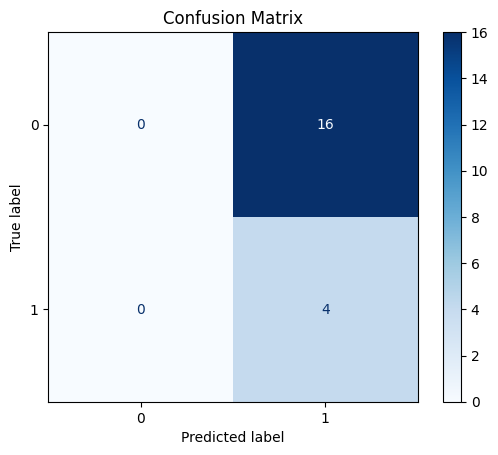

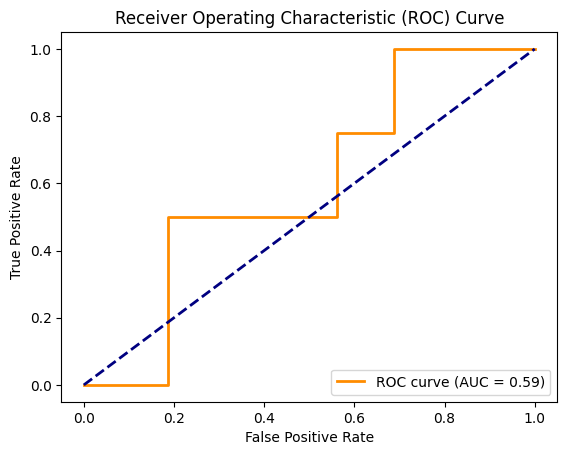

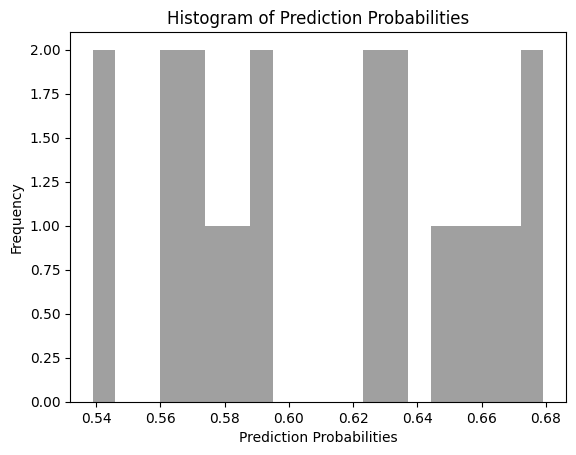

In [10]:
# Evaluate the model
model.eval()
with torch.no_grad():
    # Convert test data to PyTorch tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

    # Get the model's predictions
    y_pred_probs = model(X_test_tensor)
    y_pred = (y_pred_probs >= 0.5).float()  # Convert probabilities to binary labels

    # Convert tensors to numpy arrays for compatibility
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    
    # Calculate evaluation metrics for binary classification
    accuracy = accuracy_score(y_test_np, y_pred_np)
    precision = precision_score(y_test_np, y_pred_np, average='macro', zero_division=1)
    recall = recall_score(y_test_np, y_pred_np, average='macro', zero_division=1)
    f1 = f1_score(y_test_np, y_pred_np, average='macro', zero_division=1)

    # Convert y_test_np to binary if necessary
    if len(set(y_test_np.flatten())) > 2:
        print("Converting to binary labels...")
        y_test_np = label_binarize(y_test_np, classes=[0, 1]).ravel()

    # Ensure consistent lengths
    min_length = min(len(y_test_np), len(y_pred_np))
    y_test_np = y_test_np[:min_length]
    y_pred_np = y_pred_np[:min_length]
    y_pred_probs = y_pred_probs[:min_length]

    # Print evaluation results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")

    # Generate and display confusion matrix
    cm = confusion_matrix(y_test_np, y_pred_np)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    # Generate and plot ROC curve
    fpr, tpr, _ = roc_curve(y_test_np, y_pred_probs.cpu().numpy().flatten())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Plot histogram of prediction probabilities
    plt.hist(y_pred_probs.cpu().numpy(), bins=20, alpha=0.75, color="gray")
    plt.xlabel("Prediction Probabilities")
    plt.ylabel("Frequency")
    plt.title("Histogram of Prediction Probabilities")
    plt.show()
